In [ ]:
# Loading libraries

from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


# Background work done -
As the project seeks to predict the price patterns of the stocks on the S&P 500, the project’s model is trained and tested on historical data of the S&P 500. In order to do this, we have downloaded a .csv file of the historical data of the S&P 500 from the New York Times website, where they allow you to download any section of historical data of various stock indices. For the project, we have chosen to build the model on data from 21st April, 1980 to 18th April, 2022.

## Step 1 - Loading the data into the project:

All of the decisions about buying or selling are made on the first trading day of the month, as our analysis of the historical data is monthly based, thus this model does not do live trading.

In [ ]:
start_date=datetime.datetime(1980, 4, 21)
end_date=datetime.datetime(2022,4,18)
# This will make a data frame of the data
df=pd.read_csv("/content/sample_data/SP500HistoricalPrices.csv")
# This will copy the date column as the index of the data frame
df.index=pd.to_datetime(df["Date"])
# Since we'll have the index as date, and another date column, we delete that date column here
df=df.drop("Date",axis=1)

In [ ]:
# The dataframe df
print(df)

               Open     High      Low    Close
Date                                          
2022-04-18  4385.63  4410.31  4370.30  4391.69
2022-04-14  4449.12  4460.46  4390.77  4392.59
2022-04-13  4394.30  4453.92  4392.70  4446.59
2022-04-12  4437.59  4471.00  4381.34  4397.45
2022-04-11  4462.64  4464.35  4408.38  4412.53
...             ...      ...      ...      ...
1980-04-25   105.16   105.16   105.16   105.16
1980-04-24   104.40   104.40   104.40   104.40
1980-04-23   103.73   103.73   103.73   103.73
1980-04-22   103.43   103.43   103.43   103.43
1980-04-21    99.80    99.80    99.80    99.80

[10589 rows x 4 columns]


We produce a dataframe object with the means of the data at each month and the first trading day of the month price. This will help us formulate our trading strategy. We obtain the monthly means through the following command:

In [ ]:
dfm=df.resample("M").mean()
# We want all elements of the sequence but the last one
dfm=dfm[:-1] # As we said, we do not consider the month of end_date
print(dfm.head())
print(dfm.tail())

                  Open        High         Low       Close
Date                                                      
1980-04-30  104.288750  104.288750  104.288750  104.288750
1980-05-31  107.694286  107.993810  107.221429  107.694286
1980-06-30  114.546667  115.620476  113.459048  114.546667
1980-07-31  119.832727  120.838636  118.516818  119.832727
1980-08-31  123.496667  124.799524  122.463810  123.496667
                   Open         High          Low        Close
Date                                                          
2021-11-30  4670.937619  4688.184762  4649.419048  4667.386667
2021-12-31  4669.681818  4701.581818  4642.169545  4674.772727
2022-01-31  4585.263000  4619.576000  4528.042000  4573.815500
2022-02-28  4436.878947  4473.607368  4392.072632  4435.980526
2022-03-31  4388.294348  4424.881739  4351.570000  4391.265217


We then list out the first trading days of each month -- We’ll use this list later:


In [ ]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

# Entering in the first day of each month that we have data for
first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))

# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr

In [ ]:
print(first_days)

[Timestamp('1980-04-21 00:00:00'), Timestamp('1980-05-01 00:00:00'), Timestamp('1980-06-02 00:00:00'), Timestamp('1980-07-01 00:00:00'), Timestamp('1980-08-01 00:00:00'), Timestamp('1980-09-02 00:00:00'), Timestamp('1980-10-01 00:00:00'), Timestamp('1980-11-03 00:00:00'), Timestamp('1980-12-01 00:00:00'), Timestamp('1981-01-02 00:00:00'), Timestamp('1981-02-02 00:00:00'), Timestamp('1981-03-02 00:00:00'), Timestamp('1981-04-01 00:00:00'), Timestamp('1981-05-01 00:00:00'), Timestamp('1981-06-01 00:00:00'), Timestamp('1981-07-01 00:00:00'), Timestamp('1981-08-03 00:00:00'), Timestamp('1981-09-01 00:00:00'), Timestamp('1981-10-01 00:00:00'), Timestamp('1981-11-02 00:00:00'), Timestamp('1981-12-01 00:00:00'), Timestamp('1982-01-04 00:00:00'), Timestamp('1982-02-01 00:00:00'), Timestamp('1982-03-01 00:00:00'), Timestamp('1982-04-01 00:00:00'), Timestamp('1982-05-03 00:00:00'), Timestamp('1982-06-01 00:00:00'), Timestamp('1982-07-01 00:00:00'), Timestamp('1982-08-02 00:00:00'), Timestamp('19

In order to compare the variation in prices in the portfolio month to month, we shall create a column ‘rapp’ which will be the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month.

In [ ]:
# First day of current month
dfm["fd_cm"]=first_days[:-1]
# First day of next month
dfm["fd_nm"]=first_days[1:]
# Opening price on first day of current month
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1]," Open"])
# Opening price on first day of new month
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:]," Open"])
# Comparison of opening price of first day of previous month with new month
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [ ]:
print(dfm.head())
print(dfm.tail())

                  Open        High         Low       Close      fd_cm  \
Date                                                                    
1980-04-30  104.288750  104.288750  104.288750  104.288750 1980-04-21   
1980-05-31  107.694286  107.993810  107.221429  107.694286 1980-05-01   
1980-06-30  114.546667  115.620476  113.459048  114.546667 1980-06-02   
1980-07-31  119.832727  120.838636  118.516818  119.832727 1980-07-01   
1980-08-31  123.496667  124.799524  122.463810  123.496667 1980-08-01   

                fd_nm  fd_cm_open  fd_nm_open      rapp  
Date                                                     
1980-04-30 1980-05-01       99.80      105.46  1.056713  
1980-05-31 1980-06-02      105.46      110.76  1.050256  
1980-06-30 1980-07-01      110.76      114.93  1.037649  
1980-07-31 1980-08-01      114.93      121.21  1.054642  
1980-08-31 1980-09-02      121.21      123.74  1.020873  
                   Open         High          Low        Close      fd_cm  \
Date 

We then add columns containing the moving averages at 1 and 2 years.

In [ ]:
# Plots the 1 year moving average at each month
dfm["mv_avg_12"] = dfm[" Open"].rolling(window=12).mean().shift(1)
# Plots the 2 year moving average at each month
dfm["mv_avg_24"]= dfm[" Open"].rolling(window=24).mean().shift(1)
# Each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm)

                   Open         High          Low        Close      fd_cm  \
Date                                                                        
1980-04-30   104.288750   104.288750   104.288750   104.288750 1980-04-21   
1980-05-31   107.694286   107.993810   107.221429   107.694286 1980-05-01   
1980-06-30   114.546667   115.620476   113.459048   114.546667 1980-06-02   
1980-07-31   119.832727   120.838636   118.516818   119.832727 1980-07-01   
1980-08-31   123.496667   124.799524   122.463810   123.496667 1980-08-01   
...                 ...          ...          ...          ...        ...   
2021-11-30  4670.937619  4688.184762  4649.419048  4667.386667 2021-11-01   
2021-12-31  4669.681818  4701.581818  4642.169545  4674.772727 2021-12-01   
2022-01-31  4585.263000  4619.576000  4528.042000  4573.815500 2022-01-03   
2022-02-28  4436.878947  4473.607368  4392.072632  4435.980526 2022-02-01   
2022-03-31  4388.294348  4424.881739  4351.570000  4391.265217 2022-03-01   

The moving averages of the past 12 and 24 months are included in each month of dfm after excluding the current month. We will also remove the first 24 months as they do not have the 2 Year Moving Average. We then divide the dfm data into training and testing sets.

In [ ]:
print(dfm.loc["1981-05","mv_avg_12"])
print(dfm.loc["1980-05":"1980-04"," Open"])
print(dfm.loc["1980-05":"1980-04"," Open"].mean())

Date
1981-05-31    126.701506
Freq: M, Name: mv_avg_12, dtype: float64
Series([], Freq: M, Name:  Open, dtype: float64)
nan


In [ ]:
# Removing the first two years from dfm because we cannot calculate two year moving average on it
dfm=dfm.iloc[24:,:]
print(dfm.index)

DatetimeIndex(['1982-04-30', '1982-05-31', '1982-06-30', '1982-07-31',
               '1982-08-31', '1982-09-30', '1982-10-31', '1982-11-30',
               '1982-12-31', '1983-01-31',
               ...
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31'],
              dtype='datetime64[ns]', name='Date', length=480, freq='M')


In [ ]:
# We'll use the first 400 rows of the data (1982-2015) for training 
# and the next 80 rows of the data (2015-2020) for testing the accuracy of our LSTM Model
# in predicting stock trends

mtest=80
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 
print(train.head)
print(train.tail)
print(test.head)
print(test.tail)

<bound method NDFrame.head of                    Open         High          Low        Close      fd_cm  \
Date                                                                        
1982-04-30   116.306667   117.042381   115.013810   116.306667 1982-04-01   
1982-05-31   116.352500   117.452000   115.561000   116.352500 1982-05-03   
1982-06-30   109.697727   110.748182   108.788182   109.697727 1982-06-01   
1982-07-31   109.375714   110.448571   108.345238   109.375714 1982-07-01   
1982-08-31   109.650455   110.885455   108.191818   109.650455 1982-08-02   
...                 ...          ...          ...          ...        ...   
2015-03-31  2081.527273  2090.510000  2069.787273  2079.990455 2015-03-02   
2015-04-30  2094.028095  2102.734286  2085.031429  2094.862857 2015-04-01   
2015-05-31  2111.099500  2119.615000  2103.135000  2111.943500 2015-05-01   
2015-06-30  2101.394545  2109.400455  2092.077273  2099.283636 2015-06-01   
2015-07-31  2092.989545  2102.516818  2083.963

## Step 2 - Creating functions that will help us calculate our gross and net yields generated:

The v vector determines which months we will remain in the market.

In [ ]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [ ]:
# Here we define the long term capitals gains tax and the brokerage commission in order to 
# obtain the actual profit we yield from our investments on the S&P 500, when trading in India.

tax_cg=0.20
comm_bk=0.0025

In [ ]:
# We will use this function in the function yield_net()

# Given any vector v of ones and zeros, this function gives the corresponding vectors of 'islands' of ones of v and their number. 
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3
# So it just seperates out the clumps of 1 interspersed between all the 0s
#!!!!!!!
def expand_islands2D(v):
    
    # Get the starts and stops of each 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

In [ ]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

## Step 3 - Define the LSTM model:

We want to use a LSTM neural network to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market


In [ ]:
# We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each 
# step we want to predict the opening price of the first day of the next month: in this way we will be able
# to find the vector v which selects the months during which we are going to stay in the market


def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        # Whatever window size we put, it will shift the data to the left
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
      
    # Removes the null values from the dataset.
    data.dropna(axis=0, inplace=True)
    return(data)

In [ ]:
# Scaler is an object we will use to normalise the values
scaler=MinMaxScaler(feature_range=(0,1)) 
# The below line is used to normalise the values in each column (The highest value is set as 1 and the other values in the 
# the column are normalised according to that)
dg=pd.DataFrame(scaler.fit_transform(dfm[[" High"," Low"," Open"," Close","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
print(dg)
# Takes the first 8 columns and puts it into dg0
dg0=dg[[0,1,2,3,4,5,6,7]]
print(dg0)

window=4
window_compare = 10
# Makes 4 windows and adds it over and over as columns, thus creating 8 x 5 columns = 40
dfw=create_window(dg0,window)
dfw_compare = create_window(dg0,window_compare)
print(dfw)
print(dfw.shape)
print(dfw_compare.shape)

# Creates 3D Matrix of (480 Rows, 5 Windows, 8 Columns)
X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
X_dfw_compare=np.reshape(dfw_compare.values,(dfw_compare.shape[0],window_compare+1,8))
print(X_dfw.shape)
print(X_dfw_compare.shape)
# Prints the first 4 rows
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

# Contains the values for fd_nm_open price for all 480 entries (This is what we need to predict)
y_dfw=np.array(dg[7][window:])
y_dfw_compare=np.array(dg[7][window_compare:])
print("y_dfw")
print(y_dfw)

            0         1         2         3         4         5         6  \
0    0.001436  0.001502  0.001519  0.001518  0.001088  0.001874  0.000141   
1    0.001525  0.001623  0.001529  0.001528  0.001735  0.001519  0.000275   
2    0.000065  0.000131  0.000071  0.000071  0.000636  0.001219  0.000372   
3    0.000000  0.000034  0.000000  0.000000  0.000000  0.000777  0.000318   
4    0.000095  0.000000  0.000060  0.000060  0.000058  0.000391  0.000201   
..        ...       ...       ...       ...       ...       ...       ...   
475  0.997082  1.000000  1.000000  0.998382  0.964124  0.932506  0.938142   
476  1.000000  0.998404  0.999725  1.000000  0.962454  0.954557  0.955718   
477  0.982138  0.973272  0.981218  0.977886  1.000000  0.973677  0.972454   
478  0.950345  0.943331  0.948689  0.947695  0.944625  0.989086  0.987107   
479  0.939732  0.934412  0.938038  0.937901  0.911124  1.000000  1.000000   

            7  
0    0.001735  
1    0.000636  
2    0.000000  
3    0.0000

In [ ]:
# Here we do the test and train split for the dataset.

X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

X_trainw_compare=X_dfw_compare[:-mtest-1,:,:]
X_testw_compare=X_dfw_compare[-mtest-1:,:,:]
y_trainw_compare=y_dfw_compare[:-mtest-1]
y_testw_compare=y_dfw_compare[-mtest-1:]

In [ ]:
def model_lstm(window,features):
    # Here we construct the architecture of the LSTM Model.
    model=Sequential() 
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    
    # We use 'mean square error' for loss function (any errors) and 'adam' stands for adaptive moment estimation (the variable learning rate based on the
    # batches of data) for optimizing the model

    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [ ]:
from keras import callbacks

# We use earlystopping to prevent from overfitting the model with data. We found that when the model was overfitted, the val_loss started increasing
# as time went on, and the model was finding it difficult to adapt to price changes. We tried to put patience at 25, but found that the training stopped
# after too few epochs, but 40 was the approximate value of patience in which we observed the best results.

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 40, 
                                        restore_best_weights = True)

Epoch 1/500
17/17 [==============================] - 5s 88ms/step - loss: 0.0072 - val_loss: 0.0479
Epoch 2/500
17/17 [==============================] - 1s 37ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 3/500
17/17 [==============================] - 1s 37ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 4/500
17/17 [==============================] - 1s 38ms/step - loss: 0.0087 - val_loss: 0.0808
Epoch 5/500
17/17 [==============================] - 1s 36ms/step - loss: 0.0038 - val_loss: 0.0446
Epoch 6/500
17/17 [==============================] - 1s 38ms/step - loss: 0.0017 - val_loss: 0.0244
Epoch 7/500
17/17 [==============================] - 1s 37ms/step - loss: 9.0485e-04 - val_loss: 0.0127
Epoch 8/500
17/17 [==============================] - 1s 37ms/step - loss: 7.2042e-04 - val_loss: 0.0081
Epoch 9/500
17/17 [==============================] - 1s 37ms/step - loss: 8.7568e-04 - val_loss: 0.0070
Epoch 10/500
17/17 [==============================] - 1s 39ms/step - loss: 0.0019 - val_

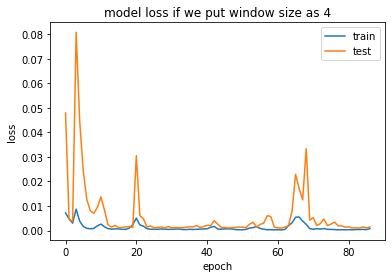

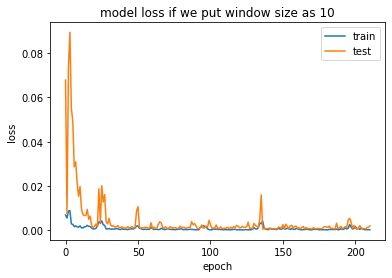

In [ ]:
model=model_lstm(window+1,8)
model_compare=model_lstm(window_compare+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=1, callbacks=[earlystopping],shuffle=False)
history_compare=model_compare.fit(X_trainw_compare,y_trainw_compare,epochs=500, batch_size=24, validation_data=(X_testw_compare, y_testw_compare), \
                  verbose=1, callbacks=[earlystopping],shuffle=False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss if we put window size as 4')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history_compare.history['loss'])
plt.plot(history_compare.history['val_loss'])
plt.title('model loss if we put window size as 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_pr=model.predict(X_trainw)

y_pr_compare=model_compare.predict(X_trainw_compare)

When the expected price for the following month is higher than the current price, we stay in the market; otherwise, we stay out.
The "in months" (as 1s) and "out months" (as 0s) are represented in the vector v.

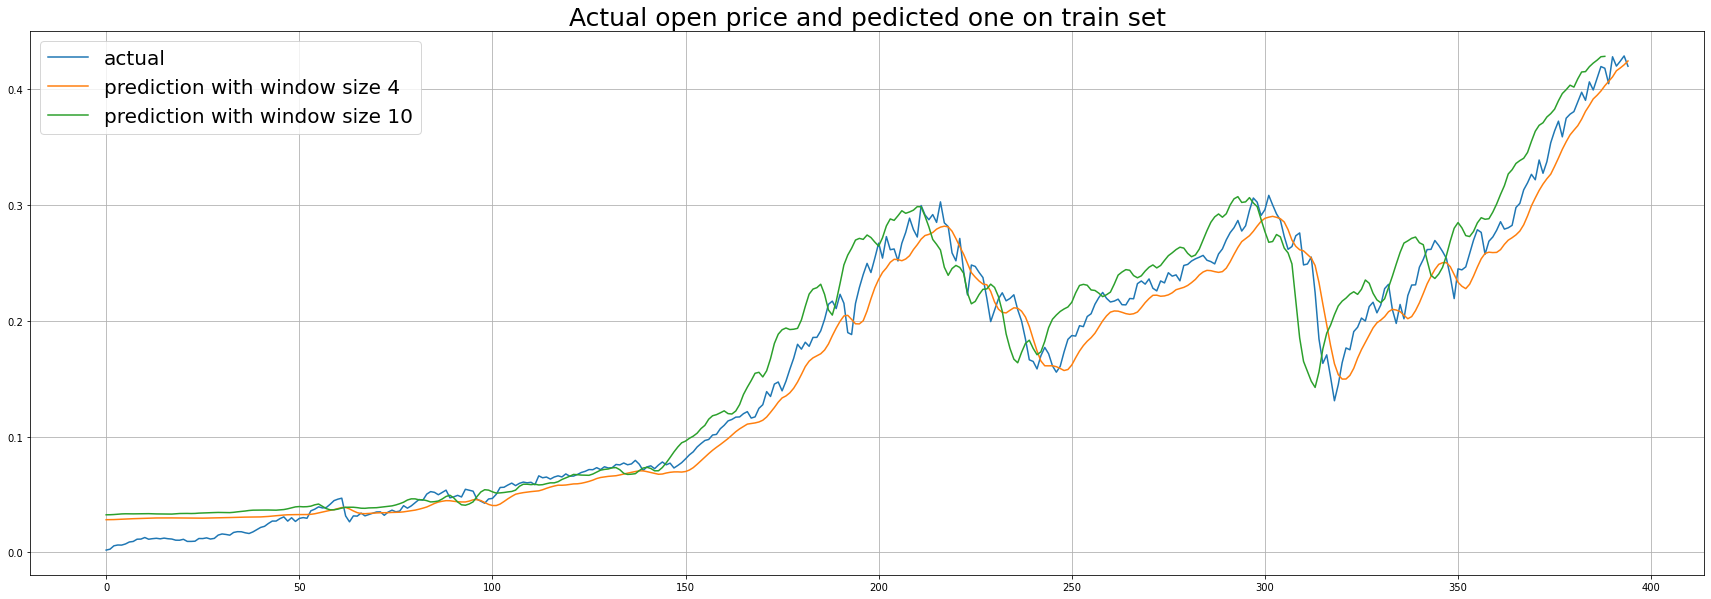

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction with window size 4")
plt.plot(y_pr_compare, label="prediction with window size 10")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [ ]:
y_pred=model.predict(X_testw)

y_pred_compare=model_compare.predict(X_testw_compare)

In [ ]:
# When the expected price for the following month is higher than the current price, we stay in the market; otherwise, we stay out.
# Calculate the n-th discrete difference along the given axis.
# Given by out[i] = a[i+1] - a[i] along the given axis
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_compare=np.diff(y_pred_compare.reshape(y_pred_compare.shape[0]),1)
# If we get a negative value, we put 0
v_lstm=np.maximum(np.sign(v),0)
v_lstm_compare=np.maximum(np.sign(v_compare),0)

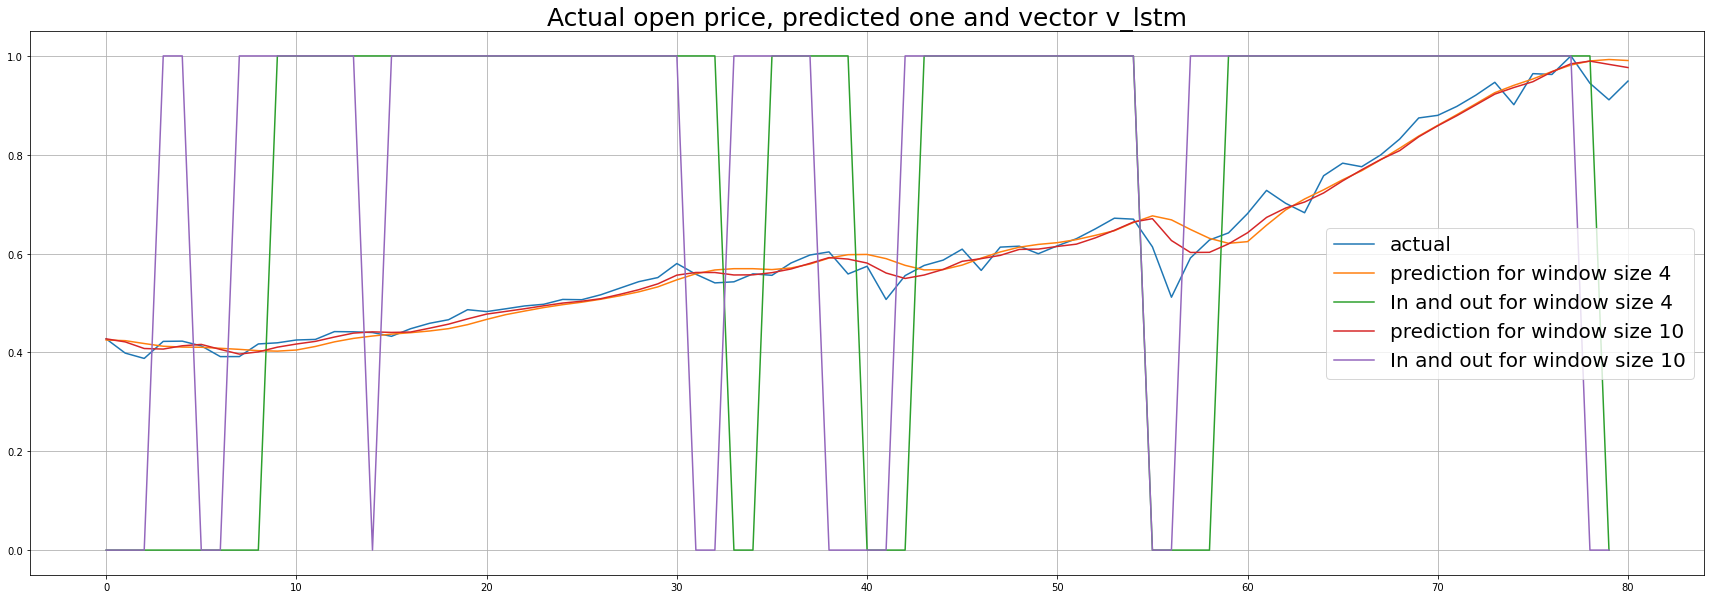

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction for window size 4")
plt.plot(v_lstm,label="In and out for window size 4")
plt.plot(y_pred_compare, label="prediction for window size 10")
plt.plot(v_lstm_compare,label="In and out for window size 10")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

The preceding plot reveals an intriguing feature of our model's prediction: it is quite good at predicting the sign of the index's first derivative, which is exactly what we require for our trading strategy.

## Step 4 - Comparing our LSTM Model with other commonly used methods:

We can now compare our LSTM trading technique to the buy and hold and moving average trading strategies.
To do so, we compute the associated vectors v_bh and v_ma, which determine the months in which we will remain in the market.

In [ ]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [ ]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

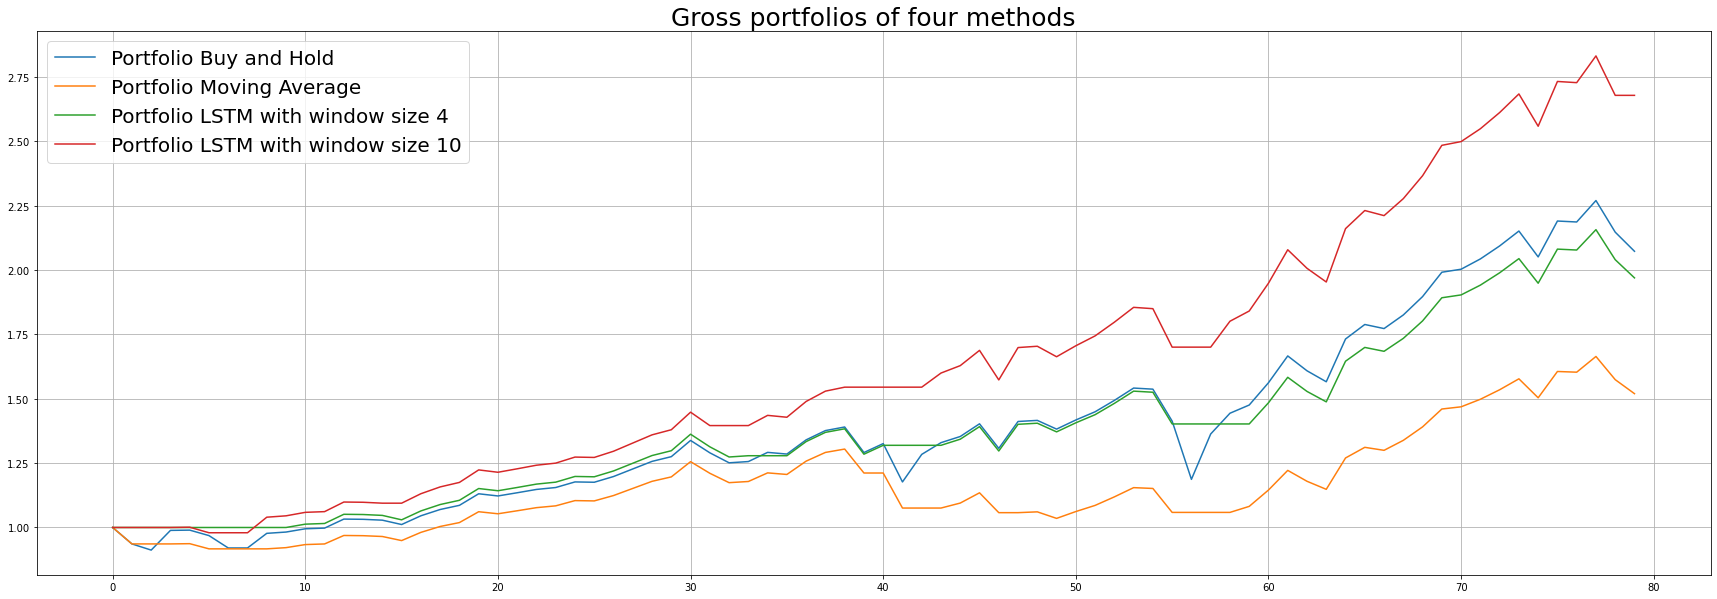

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM with window size 4")
plt.plot(gross_portfolio(test,v_lstm_compare),label="Portfolio LSTM with window size 10")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of four methods", fontsize=25)
plt.show()

Gross yield is the overall return on an investment without deducting taxes and expenses. 
Net yield is the real return to the investor.

In [ ]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})
results2=pd.DataFrame({})
results3=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM with window size 4","LSTM with window size 10"]
results1["Method"]=["Buy and hold","Moving average","LSTM with window size 4","LSTM with window size 10"]
results2["Method"]=["Buy and hold","Moving average","LSTM with window size 4","LSTM with window size 10"]
results3["Method"]=["Buy and hold","Moving average","LSTM with window size 4","LSTM with window size 10"]

vs=[v_bh,v_ma,v_lstm,v_lstm_compare]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results2["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results3["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(results2)
print("\n")
print(results3)

Test period of 6.67 years, from 2015-08-03 to 2022-04-01 

                     Method Total gross yield
0              Buy and hold          115.74 %
1            Moving average            52.0 %
2   LSTM with window size 4            97.0 %
3  LSTM with window size 10          167.92 %


                     Method Annual gross yield
0              Buy and hold            12.23 %
1            Moving average             6.48 %
2   LSTM with window size 4            10.71 %
3  LSTM with window size 10            15.93 %


                     Method Total net yield
0              Buy and hold         91.63 %
1            Moving average         31.12 %
2   LSTM with window size 4         70.91 %
3  LSTM with window size 10        117.34 %


                     Method Annual net yield
0              Buy and hold          10.25 %
1            Moving average           4.15 %
2   LSTM with window size 4           8.37 %
3  LSTM with window size 10          12.35 %
